## GCM Filters on Irregular Grids with Irregular Filter Scale

## Here we tile the 1/4 and 1/8 degree results to be on the same grid as 1/16 degree results. Then we perform the filtering on a fixed lengthscale (500km) to test whether there is resolution dependence of the filter scale (there shouldn't be)

In [7]:
%reset
import gcm_filters
import numpy as np
#import cupy as cp
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from dask.diagnostics import ProgressBar
#import cartopy
import cartopy.crs as ccrs
import cmocean
from xgcm import Grid
print('done')

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


done


In [3]:
### Execute the following cell to read in NW2 data for 1/4 (run 20), 1/8 (run 26), or 1/16 (run 28) degree 

In [8]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree 
#run=26 #1/8 degree
#run=28 #1/16 degree

fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


### Execute the following cell to read in NW2 data for 1/32 degree (run 33)

In [3]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33; factor = 1440/86400 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
init=xr.open_dataset('run33/MOM_IC.nc', decode_times=False)
av=xr.open_mfdataset(['run33/averages_00001502.nc','run33/averages_00001602.nc', 'run33/averages_00001702.nc', 'run33/averages_00001802.nc', 'run33/averages_00001902.nc'],decode_times=False,combine='by_coords')
# print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [9]:
Nx = np.size(av.xh)
xhp = av.xh
Ny = np.size(av.yh)
yhp = av.yh
print('Nx = %i, Ny = %i' %(Nx,Ny))

Nx = 240, Ny = 560


### The following are the grid types that we have so far implemented in GCM-filters:

In [10]:
list(gcm_filters.GridType)


[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>]

### To filter with fixed filter length scale, we will use the grid type: IRREGULAR_CARTESIAN_WITH_LAND, and its associated Laplacian. The Laplacian needs the following grid variables:

In [11]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND)


['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

In our example, we will filter tracer fields, i.e., fields that are defined at T-points (e.g., h, KE).

(IRREGULAR_CARTESIAN_WITH_LAND could also be used to filter U-fields or V-fields, but we would have to create the filter with different arguments for wet_mask, dxw, dyw, dxs, dys, area.)

wet_mask and area we have directly available from our model output:

In [12]:
wet_mask = fs.wet
area = fs.area_t

# Grid define for computations 
grid = Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'}});
grid

<xgcm.Grid>
X Axis (periodic):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (periodic):
  * center   yh --> outer
  * outer    yq --> center

For the remaining grid variables, recall the following conventions:

dxw = x-spacing centered at western cell edge

dyw = y-spacing centered at western cell edge

dxs = x-spacing centered at southern cell edge

dys = y-spacing centered at southern cell edge

We get these grid variables from our model output as follows:

In [13]:
dxw = xr.DataArray(data=fs.dxCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dyw = xr.DataArray(data=fs.dyCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dxs = xr.DataArray(data=fs.dxCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dys = xr.DataArray(data=fs.dyCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))

In [14]:
Ld = xr.DataArray(av.Rd1.mean(dim='time'))

Ld[1600:2880,:]=np.nan #1/4 degree 280 is center, 1120 for 1/16 800:1440, 1600:2880 for 1/32
Ld = Ld.fillna(np.nanmax(Ld))

print(np.nanmax(Ld))

445500.75


/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


The filter needs to know what the minimum grid spacing is in our model.

In [15]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_max = max(dxw.max(),dyw.max(),dxs.max(),dys.max())

dx_min = dx_min.values
dx_max = dx_max.values
dx_min, dx_max

(array(9518.17259783), array(27829.27492305))

In our example, we either choose the (fixed) filter scale to be 100km or make the filter scale a function of the local deformation radius Ld. In the latter case we have kappa_w and kappa_s as scaling factors ranging from 0-1 and the filter scale itself as the maximum deformation radius (not considering regions between 20N and 20S latitude). Note that we need: filter_scale >= dx_min.

In [16]:
#Option 1 using fixed filter scale:

filter_scale = 500000
kappa_w = Ld*0.+1. #using kappa_w and kappa_s = 1s recovers the fixed filter scale.
kappa_s = Ld*0.+1.

#Option 2 using local deformation radius as the filter scale:

#Lf = np.max(Ld.data)
#filter_scale = Lf*10
#kappa_w = Ld**2 / Lf**2
#kappa_s = Ld**2 / Lf**2

In [17]:
print('working')

working


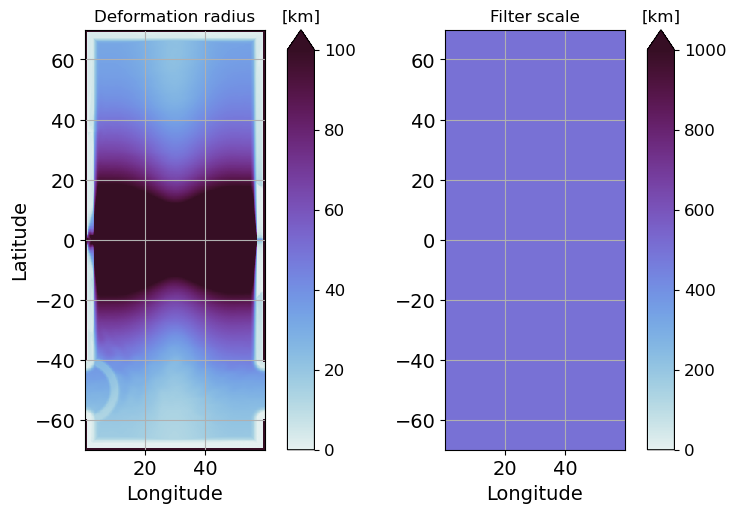

In [18]:
#Plotting Filter scale
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.35,0.7]) 
axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.55,0.2,0.35,0.7]) 
axc2 = fig.add_axes([.85, 0.2, 0.03, 0.7])

ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Deformation radius',fontsize=12)
ax2.set_title('Filter scale',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


plotted1 =ax1.pcolormesh(xhp,yhp,Ld/1000,cmap=cmocean.cm.dense,vmin=0,vmax=100)
plotted2 =ax2.pcolormesh(xhp,yhp,filter_scale*(kappa_s**0.5)/1000,cmap=cmocean.cm.dense,vmin=0,vmax=1000)


ax1.set_aspect('equal', 'box'); ax2.set_aspect('equal', 'box')
ax1.grid('on'); ax2.grid('on')

cbar1 = plt.colorbar(mappable=plotted1, cax=axc1, orientation = 'vertical',extend='max');
cbar2 = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical',extend='max');

cbar1.ax.tick_params(labelsize=12); cbar2.ax.tick_params(labelsize=12);
axc1.set_title('[km]'); axc2.set_title('[km]')

#
plt.show()

In [19]:
ufull = av.u[-1,:,:,:]; 
u_interp= grid.interp(ufull,axis='X').fillna(0.) 

vfull = av.v[-1,:,:,:];
v_interp=grid.interp(vfull,axis='Y').fillna(0.) 

h = (av.h[:,:,:,:]).mean(dim='time').fillna(0.)
depth=fs.depth_ocean



In [156]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    transition_width=2*np.pi,
    n_steps=50,
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 
               'area': area, 'kappa_w': kappa_w, 'kappa_s': kappa_s}
)
filter

Filter(filter_scale=500000, dx_min=array(1189.77157473), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=6.283185307179586, ndim=2, n_steps=50, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

In [157]:
%%time

#u_interp and v_interp are the unfiltered velocities

u_mean = (filter.apply(u_interp, dims=['yh', 'xh'])).fillna(0.)  #3D field
u_BT_mean = (u_mean*h/depth).sum(axis=0)                         #2D field
u_BC_mean = (u_mean-u_BT_mean)                                   #3D field

u_eddy = (u_interp-u_mean).fillna(0.) ;
u_BT_eddy = (u_eddy*h/depth).sum(axis=0)
u_BC_eddy = (u_eddy-u_BT_eddy)

v_mean = filter.apply(v_interp, dims=['yh', 'xh']).fillna(0.) 
v_BT_mean = (v_mean*h/depth).sum(axis=0)
v_BC_mean = (v_mean-v_BT_mean)

v_eddy = (v_interp-v_mean).fillna(0.) ;
v_BT_eddy = (v_eddy*h/depth).sum(axis=0)
v_BC_eddy = (v_eddy-v_BT_eddy)

KE_filtered   = 0.5*(u_mean**2+v_mean**2)
KE_unfiltered = 0.5*(u_interp**2+v_interp**2)

print('done')

#print(v_mean.shape,v_BT_mean.shape, v_BC_mean.shape, v_eddy.shape, v_BT_eddy.shape, v_BC_eddy.shape)

done
CPU times: user 1.52 s, sys: 256 ms, total: 1.78 s
Wall time: 1.94 s


In [136]:
test = u_eddy.round(decimals=0)

In [139]:
test.values

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [158]:
%%time

KE_BT_mean = 0.5*(u_BT_mean**2+v_BT_mean**2)
KE_BT_eddy = 0.5*(u_BT_eddy**2+v_BT_eddy**2)

KE_BC_mean = (0.5*(u_BC_mean**2+v_BC_mean**2)*h/depth).sum(axis=0)
KE_BC_eddy = (0.5*(u_BC_eddy**2+v_BC_eddy**2)*h/depth).sum(axis=0)

KE_mean = KE_BT_mean+KE_BC_mean
KE_eddy = KE_BT_eddy+KE_BC_eddy

KE_BT   = KE_BT_mean+KE_BT_eddy
KE_BC   = KE_BC_mean+KE_BC_eddy

KE_TOT = KE_BT+KE_BC
#KE_TOT_test = KE_mean+KE_eddy

print(KE_BT.shape,KE_BC.shape,KE_TOT.shape)
print(KE_filtered.shape,KE_unfiltered.shape)

(4480, 1920) (4480, 1920) (4480, 1920)
(15, 4480, 1920) (15, 4480, 1920)
CPU times: user 201 ms, sys: 47.9 ms, total: 249 ms
Wall time: 268 ms


In [159]:

plot_eddyu=u_interp[0,:,:]-u_mean[0,:,:]; 
plot_eddyv=v_interp[0,:,:]-v_mean[0,:,:];
print('done')
# plot_eddyu = plot_eddyu[1::10,1::10]
 
# plot_eddyv = plot_eddyv[1::10,1::10]
# xhp = xhp[1::10]
# yhp = yhp[1::10]
# # print(plot_eddyu.shape,xhp.shape)

done


In [ ]:

#Plotting eddy velocities for whole domain
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])


ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


ax1.set_title('Surface $u$ Eddy',fontsize=14)
ax2.set_title('Surface $v$ Eddy',fontsize=14)

levels = np.linspace(-0.3,0.3,11)
plotted1 =ax1.pcolorfast(xhp,yhp,plot_eddyu,cmap=cmocean.cm.curl,vmin=-0.3,vmax=0.3)
plotted2 =ax2.pcolorfast(xhp,yhp,plot_eddyv,cmap=cmocean.cm.curl,vmin=-0.3,vmax=0.3)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax.set_title('m/s')
# # #
# plt.clf()


In [ ]:
#Plotting filtered (mean) velocities for whole domain
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])

ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)

levels=np.linspace(-5,0,11)

ax1.set_title('Surface $u$ Mean',fontsize=14)
ax2.set_title('Surface $v$ Mean',fontsize=14)
#var = KEfull_filtered[0,:,:]
#var[200:360,:]=np.nan

plotted1 =ax1.pcolorfast(xhp,yhp,u_mean[0,:,:],cmap=cmocean.cm.curl,vmin=-0.3,vmax=0.3)
plotted2 =ax2.pcolorfast(xhp,yhp,v_mean[0,:,:],cmap=cmocean.cm.curl,vmin=-0.3,vmax=0.3)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax.set_title('m/s')
#
plt.show()

In [ ]:
#Plotting unfiltered velocities for whole domain
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])

ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)

levels=np.linspace(-5,0,11)

ax1.set_title('Surface $u$ Unfiltered',fontsize=12)
ax2.set_title('Surface $v$ Unfiltered',fontsize=12)
#var = KEfull_filtered[0,:,:]
#var[200:360,:]=np.nan

plotted1 =ax1.pcolor(xhp,yhp,u_interp[0,:,:],cmap=cmocean.cm.curl,vmin=-0.3,vmax=0.3)
plotted2 =ax2.pcolor(xhp,yhp,v_interp[0,:,:],cmap=cmocean.cm.curl,vmin=-0.3,vmax=0.3)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax.set_title('m/s')
#
plt.show()

In [ ]:
print('finished plotting')

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


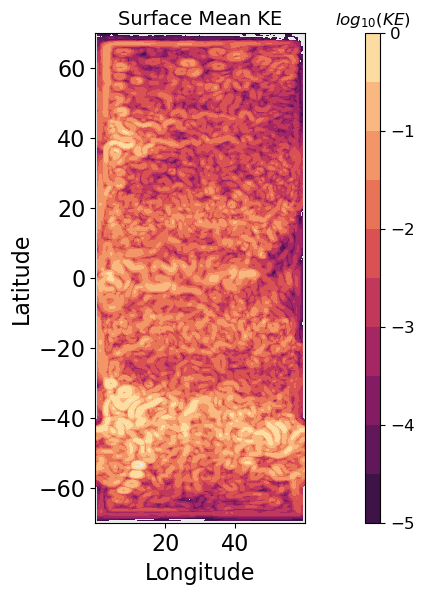

In [148]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

levels=np.linspace(-5,0,11)

#ax1.set_title('Surface KE Unfiltered',fontsize=14)
#var = KEfull[0,:,:]
ax1.set_title('Surface Mean KE',fontsize=14)
var = abs(KE_filtered[0,:,:])
#var[200:360,:]=np.nan

plotted =ax1.contourf(xhp,yhp,np.log10(var),levels=levels,cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


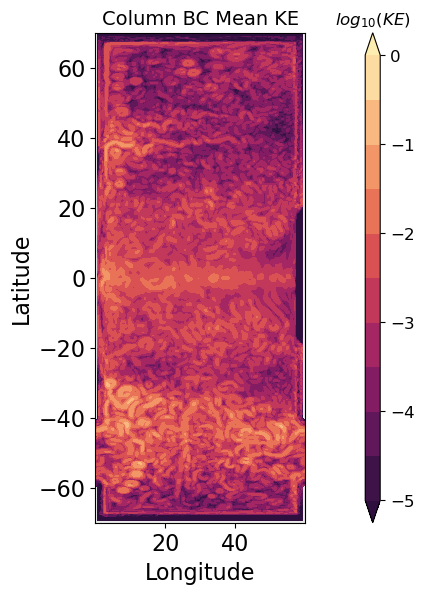

In [73]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

levels=np.linspace(-5,0,11)

#ax1.set_title('Surface KE Unfiltered',fontsize=14)
#var = KEfull[0,:,:]
ax1.set_title('Column BC Mean KE',fontsize=14)
#var[200:360,:]=np.nan

plotted =ax1.contourf(xhp,yhp,np.log10(abs(KE_BC_mean)),levels=levels,cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


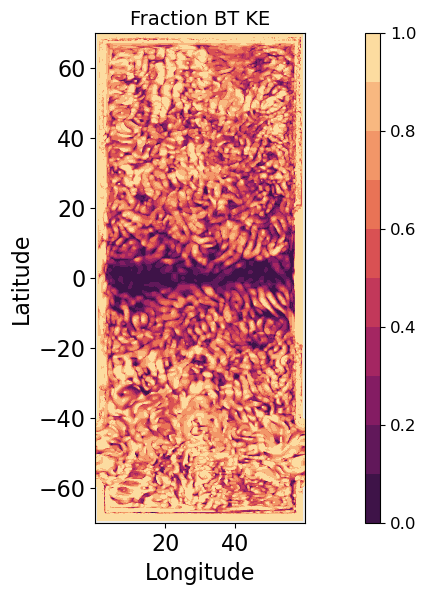

In [74]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

levels=np.linspace(0,1.,11)

#ax1.set_title('Surface KE Unfiltered',fontsize=14)
#var = KEfull[0,:,:]
ax1.set_title('Fraction BT KE',fontsize=14)
#var[200:360,:]=np.nan

plotted =ax1.contourf(xhp,yhp,KE_BT/(KE_BT+KE_BC),levels=levels,cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeW

Text(0.5, 1.0, '1/16$^\\circ$ KE fractions')

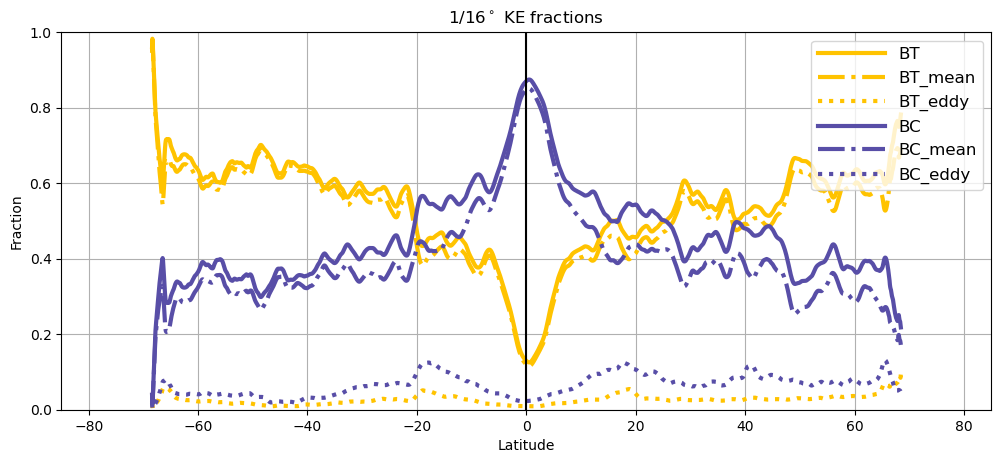

In [76]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yhp,np.convolve(np.nanmean(KE_BT/(KE_BT+KE_BC),axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.plot(yhp,np.convolve(np.nanmean(KE_BT_mean/(KE_BT+KE_BC),axis=1), np.ones((window,))/window, mode='same'),'-.',c='#FFC300',linewidth=3)
plt.plot(yhp,np.convolve(np.nanmean(KE_BT_eddy/(KE_BT+KE_BC),axis=1), np.ones((window,))/window, mode='same'),':',c='#FFC300',linewidth=3)
plt.grid()
plt.plot(yhp,np.convolve(np.nanmean(KE_BC/(KE_BT+KE_BC),axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.plot(yhp,np.convolve(np.nanmean(KE_BC_mean/(KE_BT+KE_BC),axis=1), np.ones((window,))/window, mode='same'),'-.',c='#584EA7',linewidth=3)
plt.plot(yhp,np.convolve(np.nanmean(KE_BC_eddy/(KE_BT+KE_BC),axis=1), np.ones((window,))/window, mode='same'),':',c='#584EA7',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean+fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean+fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)

plt.legend(['BT','BT_mean','BT_eddy','BC','BC_mean','BC_eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/16$^\circ$ KE fractions')

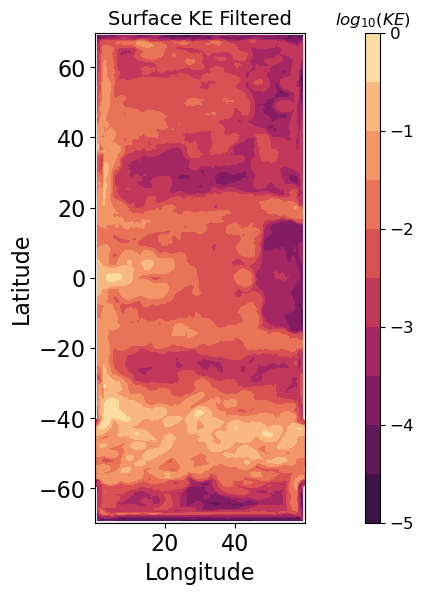

In [79]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

levels=np.linspace(-5,0,11)

#ax1.set_title('Surface KE Unfiltered',fontsize=14)
#var = KEfull[0,:,:]
ax1.set_title('Surface KE Filtered',fontsize=14)
var = KEfull_filtered[0,:,:]
#var[200:360,:]=np.nan

plotted =ax1.contourf(xhp,yhp,np.log10(var),levels=levels,cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

In [158]:
# #Plotting KE for ACC
# #fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
# fig = plt.figure(figsize=(5, 3), dpi=200, facecolor='w', edgecolor='k')

# ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
# ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
# ax1.set_facecolor((0.92, 0.92, 0.92))

# ax1.set_xlabel('Longitude',fontsize=16)
# ax1.set_ylabel('Latitude',fontsize=16)
# ax1.tick_params(labelsize=16); 
# ax2.tick_params(labelsize=14)


# ax1.set_ylim([-55,-30])
# levels=np.linspace(-5,0,11)

# plotted =ax1.contourf(xhp,yhp,np.log10(KE_unfiltered[0,:,:]),levels=levels,cmap=cmocean.cm.matter_r)
# ax1.set_title('Surface KE Unfiltered',fontsize=14)

# #plotted =ax1.contourf(xhp,yhp,np.log10(KE_filtered[0,:,:]),levels=levels,cmap=cmocean.cm.matter_r)
# #ax1.set_title('Surface KE Filtered',fontsize=14)

# cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
# cbar.ax.tick_params(labelsize=12);
# ax2.set_title('$log_{10}(KE)$')
# #
# plt.show()

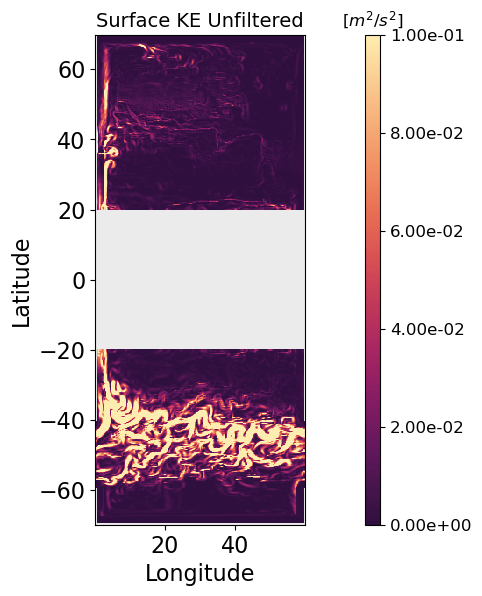

In [34]:
#Plotting KE 
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Surface KE Unfiltered',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

#KE_surface[(KE_surface)<1e-5]==1e-5
#levels=np.linspace(0.,.05,51) #not logarithmic colormap
#levels=np.linspace(0,1e-1,11)

KE_hl = KEfull[0,:,:]
KE_hl[200:360,:]=np.nan
plotted =ax1.pcolor(xhp,yhp,KE_hl,cmap=cmocean.cm.matter_r,vmin=0,vmax=1e-1)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical',format='%.2e');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$[m^2/s^2]$')
#
plt.show()

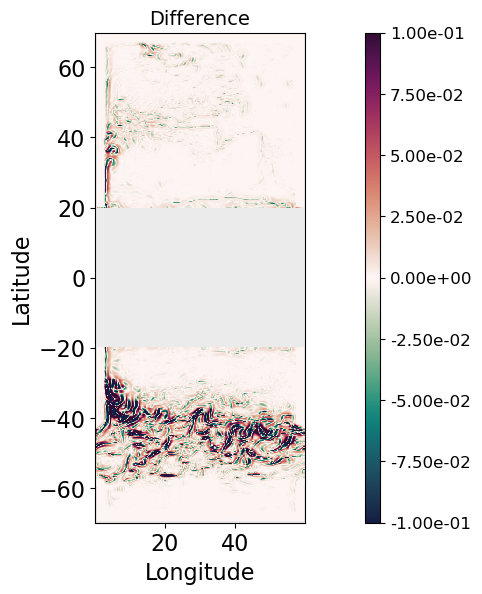

In [65]:
#Plotting KE 
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Difference',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
#ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

#KE_surface[(KE_surface)<1e-5]==1e-5
#levels=np.linspace(0.,.05,51) #not logarithmic colormap
#levels=np.linspace(-5,0,11)

diff_hl=(KEfull_filtered[0,:,:])-KEfull[0,:,:]
diff_hl[200:360,:]=np.nan
plotted =ax1.pcolor(xhp,yhp,diff_hl,cmap=cmocean.cm.curl,vmin=-1e-1,vmax=1e-1)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical',format='%.2e');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

In [35]:
filter_scale

932172.265625

In [37]:
# #Plotting KE 
# fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
# ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
# ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
# ax1.set_facecolor((0.92, 0.92, 0.92))
# ax1.set_title('Difference magnitude',fontsize=14)
# ax1.set_xlabel('Longitude',fontsize=16)
# ax1.set_ylabel('Latitude',fontsize=16)
# ax1.tick_params(labelsize=16); 
# ax2.tick_params(labelsize=14)
# #ax2.set_title('$log_{10}(m^2/s^2)$',fontsize=10)

# #KE_surface[(KE_surface)<1e-5]==1e-5
# #levels=np.linspace(0.,.05,51) #not logarithmic colormap
# levels=np.linspace(-5,0,11)
# plotted =ax1.contourf(xhp,yhp,np.log10(abs(diff_hl)),levels=levels,cmap=cmocean.cm.matter_r)

# ax1.set_aspect('equal', 'box')
# cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
# cbar.ax.tick_params(labelsize=12);
# ax2.set_title('$log_{10}(KE)$')
# #
# plt.show()